# Detectron2

In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cpu
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os, json, cv2, random, pickle
import glob
import logging

from matplotlib import pyplot as plt

#
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog


from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

import pandas as pd

I will use Faster RCNN model from model zoo

In [3]:
config_file_path = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [4]:
output_dir = "output/object_detection"
num_class = 2
device = "cpu"

Train contains 64 files

In [5]:
train_dataset_name = "Toy_train"
train_images_path = "data/train"
train_json_annot_path = "data/train_toy_annotations_COCO.json"

Validation contains 16 files

In [6]:
val_dataset_name = "Toy_val"
val_images_path = "data/validation"
val_json_annot_path = "data/val_toy_annotations_COCO.json"

Test contains 6 files

In [7]:
test_dataset_name = "Toy_test"
test_images_path = "data/test"
test_json_annot_path = "data/test_toy_annotations_COCO.json"

In [8]:
#path for saving config file
cfg_save_path = "output/OD_cfg.pickle"

Register train, validation and test datasets with the annotations

In [9]:
register_coco_instances(name=train_dataset_name, metadata={},
                        json_file=train_json_annot_path,
                        image_root=train_images_path)

register_coco_instances(name=val_dataset_name, metadata={},
                        json_file=val_json_annot_path,
                        image_root=val_images_path)

register_coco_instances(name=test_dataset_name, metadata={},
                        json_file=test_json_annot_path,
                        image_root=test_images_path)

In [10]:
def plot_samples(dataset_name, n=1):
    '''
    show random examples from the dataset with annotations
    '''
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(10, 8))
        plt.imshow(v.get_image())
        plt.axis("off")
    plt.show()

[06/15 08:41:56 d2.data.datasets.coco]: Loaded 64 images in COCO format from data/train_toy_annotations_COCO.json


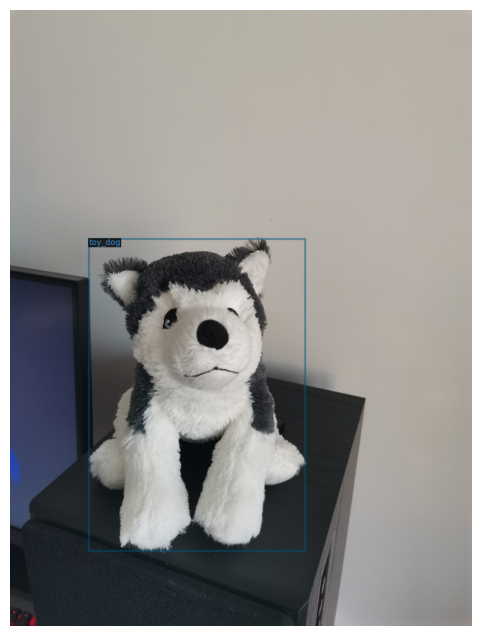

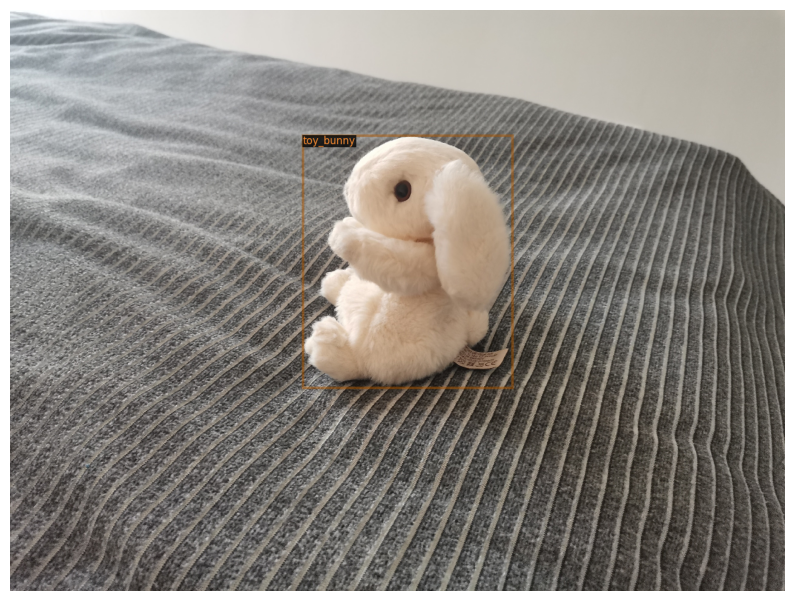

In [11]:
plot_samples(dataset_name=train_dataset_name, n=2)

In [12]:
def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, val_dataset_name, num_classes, device, output_dir):
    '''
    prepare configuration file for fine-tuning model
    '''
    cfg = get_cfg()

    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    #train set
    cfg.DATASETS.TRAIN = (train_dataset_name, )
    #validation set
    cfg.DATASETS.TEST = (val_dataset_name, )

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.SOLVER.STEPS = []

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    #make evaluation on the validation set after each 100 iterations
    cfg.TEST.EVAL_PERIOD = 100

    return cfg

Use this class to compute loss on the validation dataset

In [13]:
cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, val_dataset_name, num_class, device, output_dir)

In [14]:
#save config file
with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
#create directoru for the output of the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

### Used class LossEvalHook from [here](https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b#file-lossevalhook-py) for computing validation loss

In [16]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import numpy as np
import logging



class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [17]:
class CustomTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 08:45:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/15 08:45:29 d2.engine.train_loop]: Starting training from iteration 0


D:\Epam\CV\ObjectDetection\venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/15 08:49:09 d2.utils.events]:  eta: 2:56:53  iter: 19  total_loss: 1.327  loss_cls: 1.119  loss_box_reg: 0.1837  loss_rpn_cls: 0.00221  loss_rpn_loc: 0.001694    time: 10.7705  last_time: 13.0522  data_time: 0.1647  last_data_time: 0.0018   lr: 4.9953e-06  
[06/15 08:52:52 d2.utils.events]:  eta: 2:55:19  iter: 39  total_loss: 1.216  loss_cls: 1.004  loss_box_reg: 0.1959  loss_rpn_cls: 0.002389  loss_rpn_loc: 0.00223    time: 10.9726  last_time: 11.6971  data_time: 0.0018  last_data_time: 0.0023   lr: 9.9902e-06  
[06/15 08:56:35 d2.utils.events]:  eta: 2:53:10  iter: 59  total_loss: 0.9879  loss_cls: 0.7628  loss_box_reg: 0.185  loss_rpn_cls: 0.002525  loss_rpn_loc: 0.001843    time: 11.0219  last_time: 10.9655  data_time: 0.0018  last_data_time: 0.0017   lr: 1.4985e-05  
[06/15 09:00:10 d2.utils.events]:  eta: 2:48:08  iter: 79  total_loss: 0.7448  loss_cls: 0.5366  loss_box_reg: 0.1873  loss_rpn_cls: 0.00277  loss_rpn_loc: 0.002075    time: 10.9530  last_time: 10.1991  data_time

In [ ]:
### Plot validation metrics

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'output/object_detection'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics],
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x],
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

In [21]:
metrics_df = pd.read_json("output/object_detection/metrics.json", orient="records", lines=True)

In [22]:
metrics_df

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.001709,10190.742121,0.226562,0.041241,0.451389,19,0.184013,1.148979,0.002105,0.002239,0.000005,488.50,23.50,252.25,3.75,10.398716,1.351281
1,0.001831,10683.918000,0.547852,0.146429,0.337121,39,0.177370,1.022902,0.001974,0.002081,0.000010,489.25,22.75,252.50,3.50,12.119159,1.192150
2,0.001754,10342.774316,0.915039,0.727923,0.098646,59,0.186458,0.741430,0.000904,0.003024,0.000015,488.25,23.75,251.75,4.25,10.899657,0.954875
3,0.001799,10122.715288,0.949707,1.000000,0.000000,79,0.193671,0.534763,0.001422,0.002470,0.000020,487.50,24.50,252.00,4.00,11.064289,0.724179
4,0.001785,9864.907065,0.954590,1.000000,0.000000,99,0.176545,0.346470,0.001544,0.002211,0.000025,488.75,23.25,252.00,4.00,10.743656,0.542235
5,0.001840,9689.113324,0.953613,1.000000,0.000000,119,0.189061,0.254102,0.002023,0.001978,0.000030,488.25,23.75,252.50,3.50,11.076748,0.456321
6,0.001903,9604.681713,0.951172,1.000000,0.000000,139,0.195862,0.200659,0.000284,0.002572,0.000035,487.00,25.00,252.00,4.00,12.294662,0.409301
7,0.001887,9391.794594,0.952148,1.000000,0.000000,159,0.194684,0.170181,0.001554,0.001624,0.000040,487.50,24.50,252.50,3.50,11.579514,0.364377
8,0.001974,9178.040445,0.950684,1.000000,0.000000,179,0.191817,0.160717,0.000526,0.001697,0.000045,486.75,25.25,253.00,3.00,11.884744,0.354477
9,0.001907,8985.160920,0.952637,1.000000,0.000000,199,0.188192,0.153034,0.001379,0.001887,0.000050,487.75,24.25,252.00,4.00,11.526632,0.357971


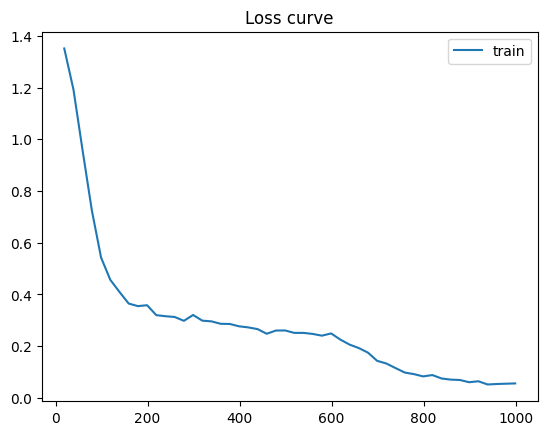

In [24]:
import pandas as pd
metrics_df = pd.read_json("output/object_detection/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

In [16]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### Test the model

In [15]:
#load config file
with open(cfg_save_path, 'rb') as f:
    cfg = pickle.load(f)

#load trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/12 13:48:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/object_detection\model_final.pth ...


In [16]:
def on_image(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (9,6))
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.show()

Test on images from test set

D:\Epam\CV\ObjectDetection\venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


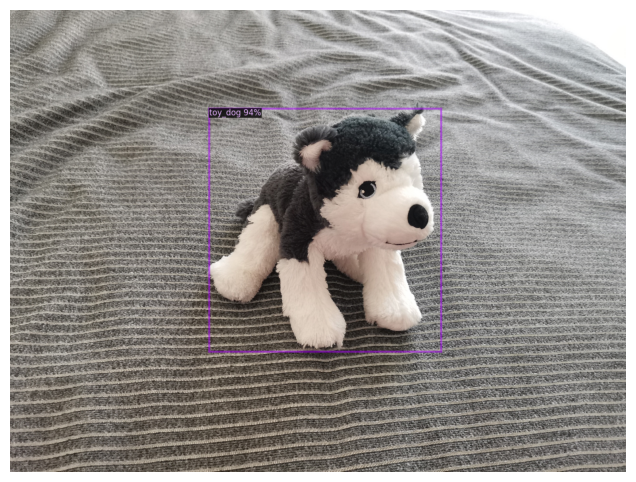

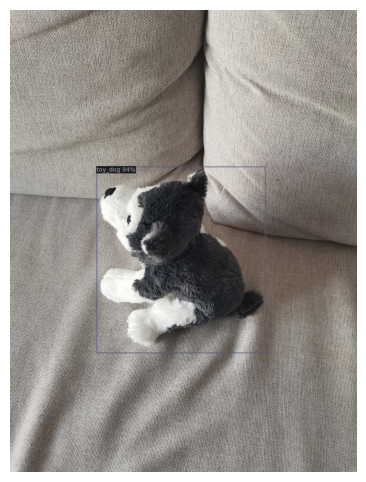

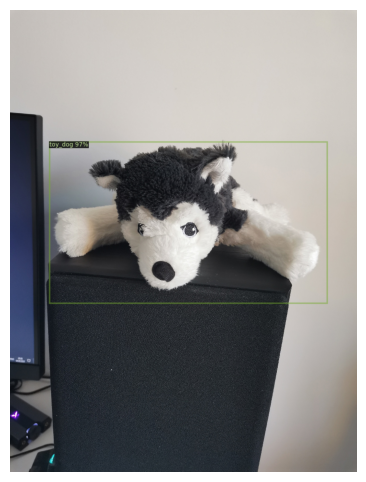

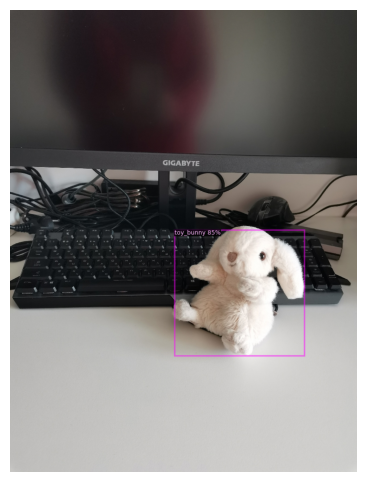

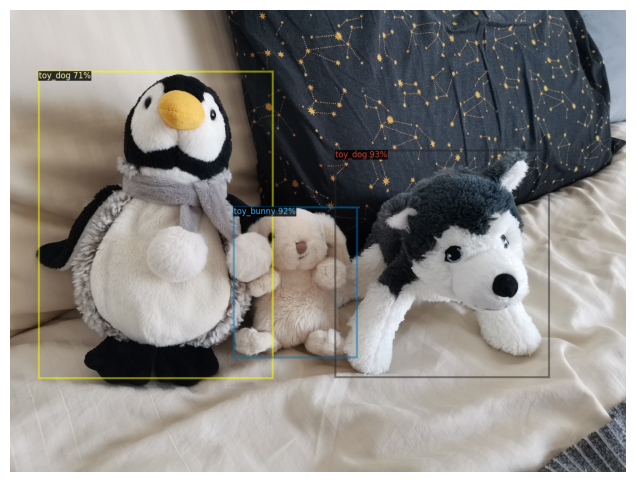

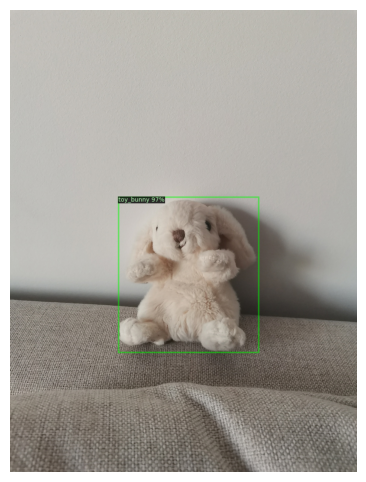

In [17]:
image_path = "data/test"
for filename in glob.glob(image_path + "/*.jpg"):
    on_image(filename, predictor)

### Evaluate the performance of the model

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Toy_test", output_dir="evaluation")
val_loader = build_detection_test_loader(cfg, "Toy_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/12 13:48:46 d2.data.datasets.coco]: Loaded 6 images in COCO format from data/test_toy_annotations_COCO.json
[06/12 13:48:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/12 13:48:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/12 13:48:46 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[06/12 13:48:46 d2.data.common]: Serialized dataset takes 0.00 MiB
[06/12 13:48:46 d2.evaluation.evaluator]: Start inference on 6 batches
[06/12 13:49:03 d2.evaluation.evaluator]: Total inference time: 0:00:02.761298 (2.761298 s / iter per device, on 1 devices)
[06/12 13:49:03 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (2.291258 s / iter per device, on 1 devices)
[06/12 13:49:03 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/12 13:

# MMDetection